<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/Lecture_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to illustrate effect of using drop-out during training of feed-forward neural network for classifying MNIST digits dataset.

Based on excellent tutorial by Cory Maklin available at: https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab

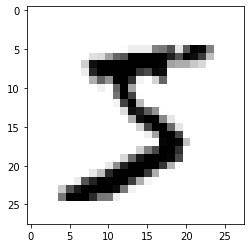

In [2]:
# Step 0: import required libraries
from keras.datasets import mnist
from matplotlib import pyplot as plt
#plt.style.use('dark_background')
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.utils import normalize, to_categorical

# Step 1: load the MNIST digits dataset pre-split into train/test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Visualize the first training exemplar:
plt.imshow(X_train[0], cmap = plt.cm.binary)
plt.show()

In [0]:
# Normalize the input images to speed training (model convergence)
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

# Use one-hot encoding of target/output variable
# Avoids unintended relationships between output values 
#(e.g. is confusing a '3' as a '2' less bad than confusing
# a '3' as a '9'? No. So avoid 3 being "closer" to '2' than '9')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# Create a model without dropout

Will:
- Create the FFNN model
- Include a 'flatten' layer to convert the input images into input vectors
- Print summary of the model, including number of parameters in each layer.


In [6]:
# Build the feed-forward neural network:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax')) # Use softmax since multi-class

# Print summary of model:
model.summary()

## Compile the model
# Use categorical crossentroly as loss function since predicting classes
# Performance measured using accurcay.
# ADAM variant of gradient descent used for training.
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_6 (Activation)    (None, 10)               

In [0]:
# Train the model using the training data
# Test data will evaluate degree of overfit (with/without dropout)

# Use a batch size of 32 (32 training samples chosen randomly per batch prior to updating weights)
# From the tutorial: "A batch size of 32 implies that we will compute the gradient and take a step in the direction of the gradient with a magnitude equal to the learning rate, after having pass 32 samples through the neural network. We do this a total of 10 times as specified by the number of epochs."

In [7]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose = 1,
    shuffle=True
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/10





54000/54000 [==============================] - 7s 127us/step - loss: 0.2764 - acc: 0.9192 - val_loss: 0.1089 - val_acc: 0.9695
Epoch 2/10
54000/54000 [==============================] - 6s 107us/step - loss: 0.1098 - acc: 0.9660 - val_loss: 0.0898 - val_acc: 0.9727
Epoch 3/10
54000/54000 [==============================] - 6s 106us/step - loss: 0.0761 - acc: 0.9764 - val_loss: 0.0803 - val_acc: 0.9755
Epoch 4/10
54000/54000 [==============================] - 6s 111us/step - loss: 0.0568 - acc: 0.9819 - val_loss: 0.0720 - val_acc: 0.9777
Epoch 5/10
54000/54000 [==============================] - 6s 107us/step - loss: 0.0436 - acc: 0.9859 - val_loss: 0.0812 - val_acc: 0.9770
Epoch 6/10
54000/54000 [==============================] - 6s 104us/step - loss: 0.0338 - acc: 0.9886 - val_loss: 0.0784 - val_acc: 0.9772
Epoch 7/10
54000/5400

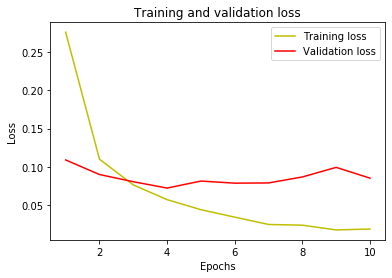

In [8]:
#We can plot the training and validation accuracies at each epoch by using the history variable returned by the fit function.

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Performance without dropout
Note from the above figure that the validation loss stops dropping after the first 3 epochs.

Let's look at the training and validation accuracy (will follow the same trend as the loss)

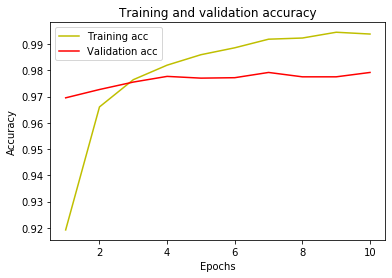

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Report final validation accuracy (97.5%):
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

10000/10000 [==============================] - 0s 27us/step


0.9754

# Add drop-out to the model
From the tutorial: "There’s some debate as to whether the dropout should be placed before or after the activation function. As a rule of thumb, place the dropout after the activate function for all activation functions other than relu. In passing 0.5, every hidden unit (neuron) is set to 0 with a probability of 0.5. In other words, there’s a 50% change that the output of a given neuron will be forced to 0."

In [13]:
# Rebuild the model, this time adding drop-out of 50% of nodes

model_dropout = Sequential()
model_dropout.add(Flatten(input_shape=(28, 28)))
model_dropout.add(Dense(128))
model_dropout.add(Dropout(0.5))
model_dropout.add(Activation('relu'))
model_dropout.add(Dense(128))
model_dropout.add(Dropout(0.5))
model_dropout.add(Activation('relu'))
model_dropout.add(Dense(10))
model_dropout.add(Activation('softmax'))
model_dropout.summary()

# Compile the model (same as above)
model_dropout.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
activation_11 (Activation)   (None, 128)              

"By providing the validations split parameter, the model will set apart a fraction of the training data and will evaluate the loss and any model metrics on this data at the end of each epoch. If the premise behind dropout holds, then we should see a notable difference in the validation accuracy compared to the previous model. The shuffle parameter will shuffle the training data before each epoch."

In [14]:
history_dropout = model_dropout.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose = 1,
    shuffle=True
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 6s 117us/step - loss: 0.5358 - acc: 0.8354 - val_loss: 0.1563 - val_acc: 0.9517
Epoch 2/10
54000/54000 [==============================] - 6s 114us/step - loss: 0.2935 - acc: 0.9154 - val_loss: 0.1227 - val_acc: 0.9640
Epoch 3/10
54000/54000 [==============================] - 6s 112us/step - loss: 0.2385 - acc: 0.9298 - val_loss: 0.1057 - val_acc: 0.9713
Epoch 4/10
54000/54000 [==============================] - 6s 117us/step - loss: 0.2143 - acc: 0.9375 - val_loss: 0.1005 - val_acc: 0.9717
Epoch 5/10
54000/54000 [==============================] - 6s 111us/step - loss: 0.1899 - acc: 0.9435 - val_loss: 0.0940 - val_acc: 0.9743
Epoch 6/10
54000/54000 [==============================] - 6s 112us/step - loss: 0.1812 - acc: 0.9471 - val_loss: 0.0818 - val_acc: 0.9762
Epoch 7/10
54000/54000 [==============================] - 6s 114us/step - loss: 0.1709 - acc: 0.9496 - val_loss: 0.0873 - v

Note that the **validation** loss achieved above using drop-out is substantially lower than the model that did not use drop-out.

Let's plot it:

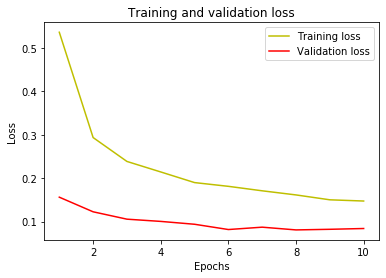

In [15]:
loss = history_dropout.history['loss']
val_loss = history_dropout.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

"As you can see, the model converged much faster and obtained an accuracy of close to 98% on the validation set, whereas the previous model plateaued around the third epoch."

In [0]:
acc = history_dropout.history['acc']
val_acc = history_dropout.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

"The accuracy obtained on the testing set isn’t very different than the one obtained from the model without dropout. This is in all likelihood due to the limited number of samples."

In [0]:
test_loss, test_acc = model_dropout.evaluate(X_test, y_test)
test_acc

#Final Thoughts
"Dropout can help a model generalize by randomly setting the output for a given neuron to 0. In setting the output to 0, the cost function becomes more sensitive to neighbouring neurons changing the way the weights will be updated during the process of backpropagation."